# PATHWAY ABUNDANCE (fr now this time please)

## step 1: get all the packages in

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import wesanderson

## step 2: load all necessary data

In [3]:
# bowtie hit summaries for propionate
compiled_bt_hit_summaries_propionate = pd.read_csv("compiled_bt_hit_summaries_propionate.csv")

compiled_bt_hit_summaries_butyrate = pd.read_csv("compiled_bt_hit_summaries_butyrate.csv")

# total read counts for each SRA accession
readCountsDF = pd.read_csv("compiled_readCounts.csv")

# gene lengths 
propionate_gene_catalogue_seqlengths = pd.read_csv("propionate_gene_catalogue_seqlengths.csv")
butyrate_gene_catalogue_seqlengths = pd.read_csv("butyrate_gene_catalogue_seqlengths.csv")

## adding read count to df

### I think the `compiled_bt_hit_summaries_butyrate` given to me is wrong?? This is an attempt to fix that

In [4]:
compiled_bt_hit_summaries_butyrate = compiled_bt_hit_summaries_butyrate[compiled_bt_hit_summaries_butyrate.pathway != "propionate"]

### function to add read count + preprocess the data frames as required

In [5]:
def add_read_count(file, readCountsDF):
    return file.merge(readCountsDF, how="left", on="read_accession").drop(columns=['pathway']).set_index("read_accession").transpose()

### actually process the data frames

In [6]:
compiled_bt_hit_summaries_propionate = add_read_count(compiled_bt_hit_summaries_propionate, readCountsDF)

compiled_bt_hit_summaries_butyrate = add_read_count(compiled_bt_hit_summaries_butyrate, readCountsDF)

## gene length correction

### the function for gene length correction

In [7]:
def gene_length_correction(gene_catalogue_seqlengths, compiled_bt_hit_summaries, pathway):

    gene_length_df = gene_catalogue_seqlengths.set_index("gene")

    df = compiled_bt_hit_summaries

    new = compiled_bt_hit_summaries.copy()

    # first replace the values in new with the gene length of that gene
    for gene in compiled_bt_hit_summaries.index:
        
        if gene in gene_length_df.index:
        
            gene_length = gene_length_df.loc[gene].at["length"]

            new.loc[gene] = [gene_length] * len(new.columns)

    # then divide what would have been reads_gene by the actual values
    new = df.div(new)

    # then divide by the total amount of reads
    for read in df:

        total_reads_for_sample = df[read].iat[-1]

        new[read] = df[read].div(total_reads_for_sample)

    new.to_csv("compiled_bt_hit_summaries_" + pathway + "_length_corrected")

    return new

### running the code for gene length correction

In [8]:
compiled_bt_hit_summaries_propionate_length_corrected = gene_length_correction(propionate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_propionate, "propionate")

compiled_bt_hit_summaries_butyrate_length_corrected = gene_length_correction(butyrate_gene_catalogue_seqlengths, compiled_bt_hit_summaries_butyrate, "butyrate")

## useful setup for calculating pathway abundances

In [9]:
pathway_gene_lists = []
pathways = []
pathway_dict = {}
pathway_length_dict = {}

# loop through the entire directory of gene lists
for file in os.listdir("geneLists"):

    # create a filename in the form of "geneLists/filename"
    file_n = "geneLists/" + str(file)

    # get the actual pathway from the filename
    pathway = str(file).replace("_gene_list.txt", "")

    # get the list of genes in each file
    geneList = [line.rstrip() for line in open(file_n)]

    pathways.append(pathway)

    # this my way of bypassing that strange assign function from R
    pathway_dict[pathway] = geneList

    # pathway_length_dict[pathway + "_pathway_length"] = len(geneList)

    pathway_length_dict[pathway] = len(geneList)
    
    pathway_gene_lists.append(geneList)

# turn the gene pathways list of lists into a pandas dataframe, using `pathways` as the column names

gene_pathways_df = pd.DataFrame(pathway_gene_lists).transpose()

gene_pathways_df.columns = pathways

gene_pathways_df

,acetylCoA_buk,P3,P1_SP,aminobutyrate_buk,P1_WWC,lysine,glutarate,P2,acetylCoA_but,aminobutyrate_but
0,buk,fucO,methylmalonyl-CoA-mutase-EC5-4-99-2,buk,methylmalonyl-CoA-mutase-EC5-4-99-2,kal,hgdC,lcdA,but,but
1,hbd,pduP,methylmalonyl-CoA-epimerase-EC5-1-99-1,ptb,methylmalonyl-CoA-epimerase-EC5-1-99-1,kamA,hgdB,lcdB,hbd,abfD
2,ptb,pduC,methylmalonyl-CoA-decarboxylaseGamma-KOK23351,abfD,methylmalonyl-CoA-carboxyltransferase12S-KOK17489,kamD,hgdA,lcdC,thl,abfH
3,thl,pduD,methylmalonyl-CoA-decarboxylaseDelta-KOK23352,abfH,methylmalonyl-CoA-carboxyltransferase5S-KOK03416,kamE,gctA,acrC,bcd,abfT
4,bcd,pduE,methylmalonyl-CoA-decarboxylaseBeta-KOK20509,abfT,methylmalonyl-CoA-carboxyltransferase1-3S-KOK1...,kce,gctB,pct,cro,bcd
5,cro,pduL,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,bcd,None,kdd,gcdB,None,None,None
6,None,pduW,None,None,None,atoA,gcdA,None,None,None
7,None,None,None,None,None,atoD,but,None,None,None
8,None,None,None,None,None,bcd,buk,None,None,None
9,None,None,None,None,None,None,ptb,None,None,None


## calculating pathway abundances

### generate the dataframe to put everything in

In [10]:
# input: give a list of all dataframes that you wish to consider

def generate_final_df(gene_catalogues, columnNames):

    # get all the gene names from the gene catalogues
    index_list = []
    for catalogue in gene_catalogues:
        index_list += list(catalogue.gene)

    # return a final dataframe with all the gene names as the index, and the column names as specified
    # rename index of this dataframe to "gene_full_name"
    return pd.DataFrame(index = index_list, columns = columnNames)

### create the dataframe to put everything in, using the function `generate_final_df` 

In [11]:
colNames = ["gene_name_short", "overall_pathway"]

gene_catalogue_list = [propionate_gene_catalogue_seqlengths]

propionate_table_base = generate_final_df(gene_catalogue_list, colNames)

propionate_table_base

,gene_name_short,overall_pathway
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN,NaN
...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,NaN,NaN
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,NaN,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,NaN,NaN
Roseburia-inulinivorans-strain-AF28-15_pduW,NaN,NaN


### create the "short" gene names and add them to the table

#### the `short_names` function just makes the list comprehension a little nicer to do 

In [12]:
def short_names(df):

    df["gene_name_short"] = [gene.split("_")[-1] for gene in list(df.index.values)]

    return df

#### now actually the short gene names onto the desired table(s)

In [13]:
propionate_table_base = short_names(propionate_table_base)

propionate_table_base

,gene_name_short,overall_pathway
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,NaN
...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,NaN
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,NaN
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,NaN


### `get_overall_pathway` gets the correct overall pathways given a dataframe with gene_name_short propigated already

In [14]:
def get_overall_pathway(df, gene_pathways_df):

    overall_pathway_list = []

    genes_with_duplicates = ["methylmalonyl-CoA-mutase-EC5-4-99-2", "methylmalonyl-CoA-epimerase-EC5-1-99-1", "buk", "but"]

    result = ""

    for gene in list(df.gene_name_short):

        modified = False

        for pathway_name in gene_pathways_df:

            if gene in set(gene_pathways_df[pathway_name]):

                if gene not in genes_with_duplicates:

                    overall_pathway_list.append(pathway_name) 

                    modified = True

                    break

                else:

                    if gene == "buk":

                        overall_pathway_list.append("acetylCoA_buk/aminobutyrate_buk")

                        modified = True

                        break

                    if gene == "but":
                        
                        overall_pathway_list.append("acetylCoA_but/aminobutyrate_but")

                        modified = True

                        break


                    if gene == "methylmalonyl-CoA-mutase-EC5-4-99-2" or "methylmalonyl-CoA-epimerase-EC5-1-99-1":
                        
                        overall_pathway_list.append("P1_SP/P1_WCC")

                        modified = True

                        break


        if not modified: overall_pathway_list.append(None)

    df["overall_pathway"] = overall_pathway_list

    return df


### actually get the overall pathways using the function defined above

In [15]:
propionate_table_base = get_overall_pathway(propionate_table_base, gene_pathways_df=gene_pathways_df)

propionate_table_base

,gene_name_short,overall_pathway
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP
...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,P3
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,P3
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,P3
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,P3


### finally: pathway abundance time!

#### merge the useful information onto the normalized hit table

In [16]:
propionate_final_hit_table = propionate_table_base.merge(compiled_bt_hit_summaries_propionate_length_corrected, how = "left", left_index=True, right_index=True)

# summed_propionate = compiled_bt_hit_summaries_propionate_length_corrected.sum(axis=1)

# summed_propionate.name = "pathway_abundance"

# propionate_final_test = propionate_final_test.merge(summed_propionate, how = "left", left_index=True, right_index=True)

propionate_final_hit_table

,gene_name_short,overall_pathway,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,ERR525695,...,ERR526078,ERR526079,ERR526080,ERR526081,ERR526082,ERR526083,ERR526084,ERR526085,ERR526086,ERR526087
Alistipes-indistinctus-YIT-12060-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,NaN,NaN,NaN,NaN,1.251230e-06,NaN,NaN,NaN,...,NaN,2.366526e-07,NaN,NaN,NaN,5.635910e-07,NaN,NaN,NaN,2.518176e-07
Alistipes-onderdonkii-DSM-19147-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,3.727259e-06,5.429660e-05,6.213023e-08,NaN,1.251230e-06,4.657935e-08,NaN,NaN,...,3.030490e-08,2.721505e-06,1.583523e-05,1.731042e-08,NaN,3.796823e-06,NaN,NaN,NaN,1.028255e-06
Alistipes-putredinis-DSM-17216-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,NaN,2.591723e-08,NaN,2.471279e-08,1.049501e-05,NaN,NaN,NaN,...,NaN,2.839832e-06,2.626075e-08,NaN,NaN,1.050059e-05,1.949836e-08,NaN,NaN,9.757930e-06
Alistipes-senegalensis-JC50-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,1.150389e-07,1.295862e-07,NaN,NaN,4.085648e-07,NaN,NaN,NaN,...,NaN,2.082543e-06,1.050430e-06,NaN,NaN,1.008531e-06,NaN,NaN,NaN,NaN
Alistipes-shahii-WAL-8301-MAF-2_methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,NaN,NaN,NaN,NaN,2.400318e-06,NaN,NaN,NaN,...,NaN,3.526124e-06,6.775274e-06,1.731042e-08,NaN,7.356345e-06,NaN,NaN,NaN,1.133179e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Blautia-wexlerae-DSM-19850-MAF-2_pduW,pduW,P3,2.968003e-06,7.153156e-06,NaN,NaN,2.553530e-07,NaN,4.190496e-08,NaN,...,NaN,2.863497e-06,9.900304e-06,NaN,NaN,8.898805e-08,NaN,NaN,NaN,3.735294e-06
Enterocloster-asparagiformis-DSM-15981-MAF-2_pduW,pduW,P3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Enterocloster-bolteae-ATCC-BAA-613-MAF-2_pduW,pduW,P3,NaN,1.036689e-06,NaN,NaN,6.128473e-07,NaN,5.238120e-07,8.540938e-08,...,NaN,NaN,3.151290e-07,NaN,NaN,NaN,1.111406e-06,NaN,NaN,4.196959e-07
Roseburia-inulinivorans-strain-AF28-15_pduW,pduW,P3,9.203110e-08,1.632786e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.050430e-07,NaN,NaN,8.898805e-08,NaN,NaN,NaN,NaN


## playing around with groupby to see what I get

In [17]:
gene_short_groupby = propionate_final_hit_table.groupby(["gene_name_short", "overall_pathway"]).sum()

gene_short_groupby

,,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,ERR525695,ERR525697,ERR525698,...,ERR526078,ERR526079,ERR526080,ERR526081,ERR526082,ERR526083,ERR526084,ERR526085,ERR526086,ERR526087
gene_name_short,overall_pathway,,,,,,,,,,,,,,,,,,,,,
acrC,P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107061e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.304679e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
fucO,P3,2.645894e-06,1.277719e-05,3.727814e-07,1.482768e-07,6.894532e-07,1.630277e-07,1.047624e-06,5.693959e-07,2.174465e-07,3.003689e-08,...,0.000000e+00,3.431463e-06,0.000011,6.924166e-08,0.000000e+00,4.152776e-07,2.008331e-06,1.030292e-07,0.000000,0.000005
lcdA,P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107061e-08,0.000000e+00,0.000000e+00,0.000000e+00,3.261698e-07,0.000000e+00,...,0.000000e+00,2.366526e-08,0.000000,0.000000e+00,0.000000e+00,8.898805e-08,0.000000e+00,0.000000e+00,0.000000,0.000000
lcdB,P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.107061e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.957019e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,5.932537e-08,0.000000e+00,0.000000e+00,0.000000,0.000000
lcdC,P2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.021412e-07,0.000000e+00,0.000000e+00,0.000000e+00,1.957019e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
methylmalonyl-CoA-carboxyltransferase1-3S-KOK17490,P1_WWC,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.607184e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
methylmalonyl-CoA-carboxyltransferase12S-KOK17489,P1_WWC,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,1.731042e-08,1.720741e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
methylmalonyl-CoA-carboxyltransferase5S-KOK03416,P1_WWC,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,5.193125e-08,1.355736e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
methylmalonyl-CoA-decarboxylaseAlpha-KOK01604,P1_SP,3.616822e-05,5.450394e-05,2.236688e-06,3.212663e-07,3.894134e-05,7.021838e-05,4.988786e-05,8.626347e-06,2.892039e-05,7.614352e-05,...,7.130743e-05,2.361793e-05,0.000041,2.492700e-06,0.000000e+00,3.698937e-05,1.871842e-06,2.013190e-05,0.000101,0.000037


In [18]:
propoinate_useful_display = propionate_final_hit_table.groupby(["overall_pathway", "gene_name_short"]).sum()

# for pathway in list(overall_pathway_groupby.index.values):
   
#     if pathway in pathway_length_dict.keys():

#         overall_pathway_groupby.at[pathway, "pathway_abundance"] /= pathway_length_dict[pathway]

# overall_pathway_groupby.at['P1_SP/P1_WCC', "pathway_abundance"] /= 5.5

propoinate_useful_display

ERR525688  \
overall_pathway gene_name_short                                                    
P1_SP           methylmalonyl-CoA-decarboxylaseAlpha-KOK01604       3.616822e-05   
                methylmalonyl-CoA-decarboxylaseBeta-KOK20509        2.404312e-05   
                methylmalonyl-CoA-decarboxylaseDelta-KOK23352       3.313119e-06   
                methylmalonyl-CoA-decarboxylaseGamma-KOK23351       4.946671e-06   
P1_SP/P1_WCC    methylmalonyl-CoA-epimerase-EC5-1-99-1              4.923664e-06   
                methylmalonyl-CoA-mutase-EC5-4-99-2                 7.357886e-05   
P1_WWC          methylmalonyl-CoA-carboxyltransferase1-3S-KOK17490  0.000000e+00   
                methylmalonyl-CoA-carboxyltransferase12S-KOK17489   0.000000e+00   
                methylmalonyl-CoA-carboxyltransferase5S-KOK03416    0.000000e+00   
P2              acrC                                                0.000000e+00   
                lcdA                                                0.000000e+00   
                lcdB                                                0.000000e+00   
                lcdC                                                0.000000e+00   
                pct                                                 0.000000e+00   
P3              fucO                                                2.645894e-06   
                pduC                                                1.380466e-07   
                pduL                                                9.433187e-07   
                pduP                                                3.520189e-06   
                pduW                                                3.060034e-06   

                                                                       ERR525689  \
overall_pathway gene_name_short                                                    
P1_SP           methylmalonyl-CoA-decarboxylaseAlpha-KOK01604       5.450394e-05   
                methylmalonyl-CoA-decarboxylaseBeta-KOK20509        4.395562e-05   
                methylmalonyl-CoA-decarboxylaseDelta-KOK23352       5.157529e-06   
                methylmalonyl-CoA-decarboxylaseGamma-KOK23351       9.770796e-06   
P1_SP/P1_WCC    methylmalonyl-CoA-epimerase-EC5-1-99-1              6.375639e-06   
                methylmalonyl-CoA-mutase-EC5-4-99-2                 7.217949e-05   
P1_WWC          methylmalonyl-CoA-carboxyltransferase1-3S-KOK17490  0.000000e+00   
                methylmalonyl-CoA-carboxyltransferase12S-KOK17489   0.000000e+00   
                methylmalonyl-CoA-carboxyltransferase5S-KOK03416    0.000000e+00   
P2              acrC                                                0.000000e+00   
                lcdA                                                0.000000e+00   
                lcdB                                                0.000000e+00   
                lcdC                                                0.000000e+00   
                pct                                                 0.000000e+00   
P3              fucO                                                1.277719e-05   
                pduC                                                1.036689e-07   
                pduL                                                2.539889e-06   
                pduP                                                9.252451e-06   
                pduW                                                9.822630e-06   

                                                                       ERR525690  \
overall_pathway gene_name_short                                                    
P1_SP           methylmalonyl-CoA-decarboxylaseAlpha-KOK01604       2.236688e-06   
                methylmalonyl-CoA-decarboxylaseBeta-KOK20509        1.211540e-06   
                methylmalonyl-CoA-decarboxylaseDelta-KOK23352       9.319535e-08   
                methylmalonyl-CoA-decarboxylaseGamma-KOK23351       9.319535e-08   
P1_SP/P1_WCC    methylmalonyl-CoA-epi

In [19]:
propionate_overall_pathway_group = propionate_final_hit_table.groupby(["overall_pathway"]).sum()

propionate_overall_pathway_group = propionate_overall_pathway_group.drop("gene_name_short", axis=1)

# for pathway in list(overall_pathway_groupby.index.values):
   
#     if pathway in pathway_length_dict.keys():

#         overall_pathway_groupby.at[pathway, "pathway_abundance"] /= pathway_length_dict[pathway]

# overall_pathway_groupby.at['P1_SP/P1_WCC', "pathway_abundance"] /= 5.5

propionate_overall_pathway_group

,ERR525688,ERR525689,ERR525690,ERR525691,ERR525692,ERR525693,ERR525694,ERR525695,ERR525697,ERR525698,...,ERR526078,ERR526079,ERR526080,ERR526081,ERR526082,ERR526083,ERR526084,ERR526085,ERR526086,ERR526087
overall_pathway,,,,,,,,,,,,,,,,,,,,,
P1_SP,0.000068,0.000113,0.000004,7.660966e-07,6.986459e-05,0.000134,0.000093,0.000016,5.044760e-05,1.412335e-04,...,1.321294e-04,4.120122e-05,0.000069,3.029323e-06,5.214368e-08,6.356713e-05,0.000003,0.000038,0.000192,0.000068
P1_SP/P1_WCC,0.000079,0.000079,0.000004,3.459791e-07,6.508949e-05,0.000122,0.000111,0.000017,5.042585e-05,1.484123e-04,...,1.146434e-04,4.262114e-05,0.000074,1.376178e-05,1.746813e-06,6.160939e-05,0.000005,0.000027,0.000142,0.000060
P1_WWC,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,6.924166e-08,3.102549e-06,0.000000e+00,0.000000,0.000000,0.000000,0.000000
P2,0.000000,0.000000,0.000000,0.000000e+00,2.808883e-07,0.000000,0.000000,0.000000,1.130722e-06,0.000000e+00,...,0.000000e+00,2.366526e-08,0.000000,0.000000e+00,0.000000e+00,1.779761e-07,0.000000,0.000000,0.000000,0.000000
P3,0.000010,0.000034,0.000002,1.161501e-06,2.630136e-06,0.000003,0.000003,0.000022,9.132755e-07,3.003689e-08,...,3.030490e-08,9.111126e-06,0.000032,2.683114e-06,1.042874e-07,9.195432e-07,0.000007,0.000003,0.000000,0.000013


## random plots testing time

In [20]:
# ax.bar(list(propionate_final_test.index.values), list(propionate_final_test.pathway_abundance))

# numberOfBars = len(propionate_final_hit_table)

# temp_table = propionate_final_hit_table.drop(["gene_name_short", "overall_pathway"], axis=1)

# temp_table.plot(kind="bar", stacked=True, color = wesanderson.film_palette('Zissou'))

# plt.title("just plotting the raw data from propionate", fontsize = 16)

# plt.xlabel("samples")

# plt.ylabel("pathway abundance")

# # plt.bar(list(propionate_final_hit_table.index.values), list(propionate_final_hit_table.pathway_abundance), color=wesanderson.film_palette('Zissou'))

# # ax.set(xlabel="gene", ylabel="pathway abundance", title="propionate_final_hit_table")

# plt.show()

In [21]:
# fig, ax = plt.subplots()

# gene_short_plotting_table = gene_short_groupby.drop(["overall_pathway"], axis=1)

# sns.set_style("whitegrid")

# gene_short_plotting_table.plot(kind="bar", stacked=True, y=  color = wesanderson.film_palette('Zissou'))

# # ax.bar(list(gene_short_groupby.index.values), list(gene_short_groupby.pathway_abundance), color = wesanderson.film_palette('Zissou'))

# # ax.set(xlabel="gene", ylabel="pathway abundance", title="gene_short_groupby")

# plt.show()

In [25]:
def stackedBarDF(overall_pathway_df):

    temp_table = overall_pathway_df.transpose()

    temp_dict = {}

    for column in temp_table:

        temp_dict[column] = temp_table[column].tolist()

    samples_list = list(temp_table.index.values)

    plottingDF = pd.DataFrame(
        temp_dict,
        index = samples_list
    )

    return plottingDF

[Text(0.5, 0, 'sample'),
 Text(0, 0.5, 'pathway abundance'),
 Text(0.5, 1.0, 'overall_pathway_groupby')]

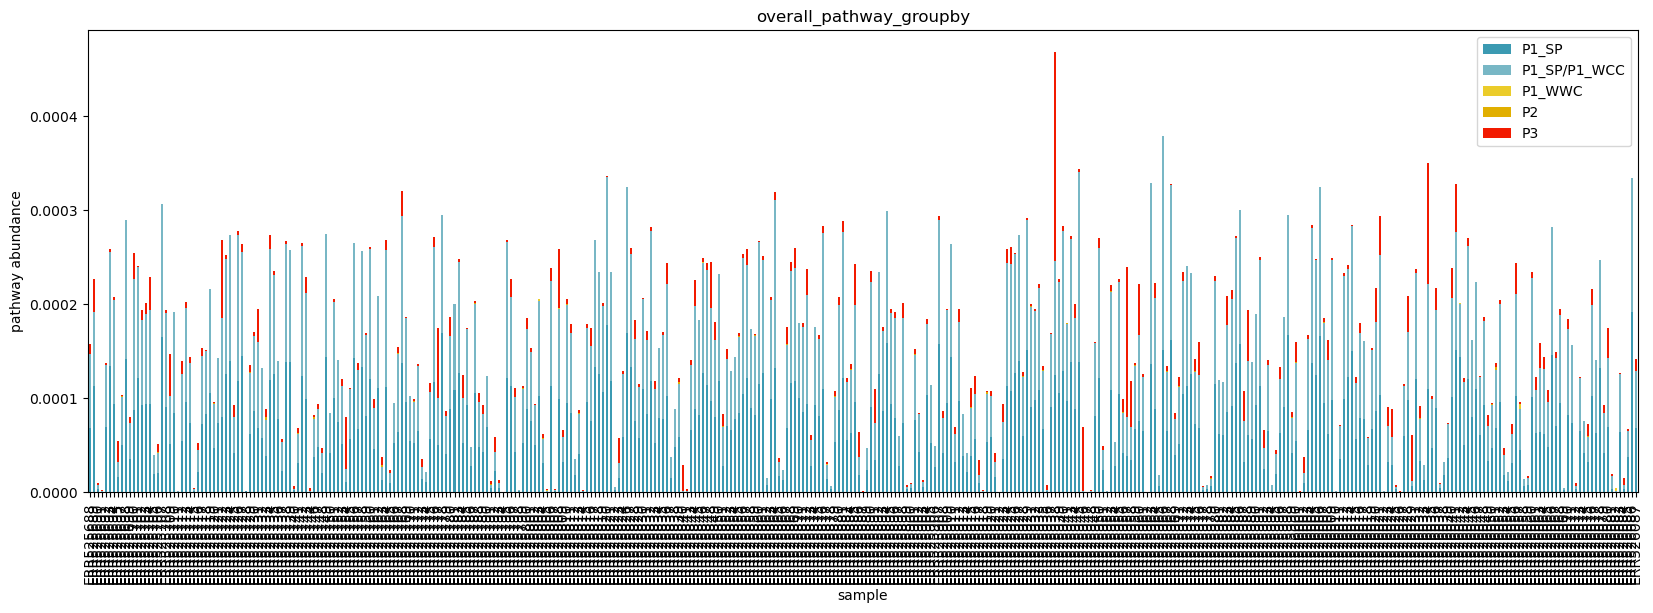

In [44]:
plottingDF = stackedBarDF(propionate_overall_pathway_group)

# plt.figure(figsize=(50,6))

plottingDF.plot.bar(stacked=True, color=wesanderson.film_palette("Zissou"), figsize=(20,6)).set(xlabel="sample", ylabel="pathway abundance", title="overall pathway groupby")

# plottingDF.plot(kind="bar", stacked=True, color = wesanderson.film_palette('Zissou'))

# plt.show()

# plt.xlabel("sample")

# plt.ylabel("pathway_abundance")

# plt.title("overall_pathway_groupby")

# plt.set(xlabel="sample", ylabel="pathway abundance", title="overall_pathway_groupby")

# plt.set_xticklabels(plt.get_xticklabels(), rotation=30)


# finalGraph.xticks(rotation=90)

In [ ]:

temp_table = propionate_overall_pathway_group.transpose()

temp_table

P1_SP_list = temp_table["P1_SP"].tolist()

P1_WWC_list = temp_table["P1_WWC"].tolist()

P1_SP_P1_WCC_list = temp_table["P1_SP/P1_WCC"].tolist()

P2_list = temp_table["P2"].tolist()

P3_list = temp_table["P3"].tolist()

samples_list = list(temp_table.index.values)

plottingDF = pd.DataFrame(
    {'P1_SP': P1_SP_list,
    "P1_SP/P1_WCC": P1_SP_P1_WCC_list,
    "P1_WCC": P1_WWC_list,
    "P2": P2_list,
    "P3": P3_list},
    index = samples_list
)

finalGraph = plottingDF.plot(kind="bar", stacked=True, color = wesanderson.film_palette('Zissou'))

finalGraph.set(xlabel="sample", ylabel="pathway abundance", title="overall_pathway_groupby")


# overall_pathway_graph = sns.barplot()

# overall_pathway_graph = overall_pathway_groupby.plot(kind="bar", stacked=True, color = wesanderson.film_palette('Zissou'), x=)

# overall_pathway_graph.set(xlabel=None)

# plt.bar(list(overall_pathway_groupby.index.values), list(overall_pathway_groupby.pathway_abundance), color=wesanderson.film_palette('Zissou'))

# ax.bar(list(overall_pathway_groupby.index.values), list(overall_pathway_groupby.pathway_abundance))

# plt.show()